In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
!pip install segmentation-models
import segmentation_models as sm
import glob
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import keras
from PIL import Image
from keras.utils import normalize
from keras.metrics import MeanIoU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [2]:
!pip install opendatasets --upgrade --quiet
import os
import opendatasets as od

dataset = 'https://www.kaggle.com/datasets/hashbanger/ph2-resized'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: augustofguiufop
Your Kaggle Key: ··········


100%|██████████| 47.9M/47.9M [00:01<00:00, 37.1MB/s]


In [3]:
SIZE_X = 192
SIZE_Y = 256

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

filelist_trainx = sorted(glob.glob('/content/ph2-resized/trainx/*.bmp'), key=numericalSort)
img_dataset = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/ph2-resized/trainy/*.bmp'), key=numericalSort)
mask_dataset = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])


In [4]:
print(img_dataset.shape)

(200, 192, 256, 3)


In [5]:
img_dataset = np.array(img_dataset, dtype=np.uint8)
expanded_mask_dataset = np.expand_dims((np.array(mask_dataset, dtype=np.float32)),3)

In [11]:
def rot_img(img, rot):
  x, y = img.shape[:2]
  img_rot = cv2.getRotationMatrix2D((x/2, y/2), rot, 1)
  img_rot = cv2.warpAffine(img.astype('float32'), img_rot, (x, y))
  return img.astype('float32')

def flip_img(img):
  img_flip = cv2.flip(img.astype('float32'), 1)
  return img_flip.astype('float32')

In [43]:
def img_augmentation(x_train, y_train):
    x_rot = []
    y_rot = []
    x_flip = []
    y_flip = []
    for i in range(len(x_train)):
      rot = np.random.randint(-40, 40)
      x = rot_img(x_train[i], rot)
      y = rot_img(y_train[i], rot)
      x_rot.append(x)
      y_rot.append(y)

      x = flip_img(x_train[i])
      y = flip_img(y_train[i])
      x_flip.append(x)
      y_flip.append(y)


    x_rot = np.array(x_rot, dtype=np.uint8)
    x_flip = np.array(x_flip, dtype=np.uint8)
    y_rot = np.array(y_rot, dtype=np.float32)
    y_flip = np.expand_dims(np.array(y_flip, dtype=np.float32), 3)

    x_train_aug = np.concatenate([x_train, x_rot, x_flip])
    y_train_aug =  np.concatenate([y_train, y_rot, y_flip])
    return x_train_aug, y_train_aug

In [33]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(img_dataset, expanded_mask_dataset, test_size = 0.10, random_state = 0)

In [34]:
print(X_train.shape)

(180, 192, 256, 3)


In [44]:
x_train_aug, y_train_aug = img_augmentation(X_train, Y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train_aug, y_train_aug, test_size = 0.20, random_state = 101)

In [45]:
print(x_train.shape)

(432, 192, 256, 3)


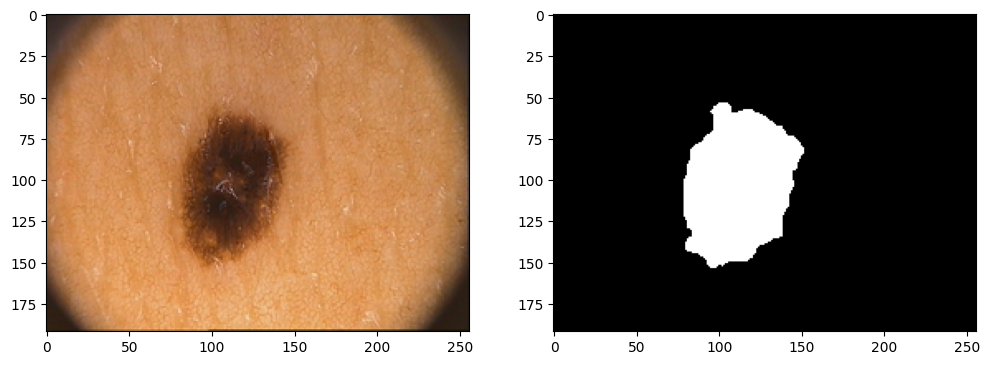

In [46]:
import random

image_number = random.randint(0, len(x_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x_train[image_number])
plt.subplot(122)
plt.imshow(y_train[image_number], cmap='gray')
plt.show()

In [47]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

In [48]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return dice

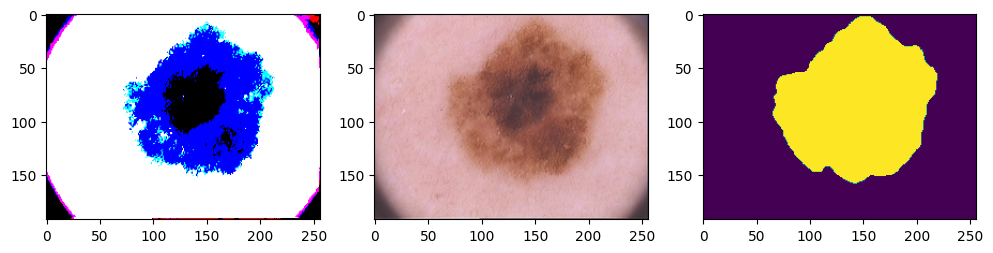

In [50]:
import random
import numpy as np

BACKBONE = 'vgg19'
preprocess_input = get_preprocessing(BACKBONE)
X_train_vgg19 = preprocess_input(x_train)

image_number = random.randint(0, len(X_train_vgg19))
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(X_train_vgg19[image_number])
plt.subplot(132)
plt.imshow(x_train[image_number])
plt.subplot(133)
plt.imshow(y_train[image_number])
plt.show()

In [51]:
print(x_train.shape)

(432, 192, 256, 3)


In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [49]:
n_classes=1
activation='sigmoid'

total_loss = sm.losses.binary_focal_dice_loss

metrics = ["accuracy", sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef]

In [55]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def makeConv(input, size, drop):
  c = Conv2D(size, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
  c = Dropout(drop)(c)
  c = Conv2D(size, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c)
  return c

def makeUpscale(input, size, drop, concat):
  u = Conv2DTranspose(size, (2, 2), strides=(2, 2), padding='same')(input)
  u = concatenate([u, concat])
  c = makeConv(u, size, drop)
  return c

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
norm = Lambda(lambda x: x / 255.)(inputs)

c1 = makeConv(norm, 16, 0.1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = makeConv(p1, 32, 0.1)
p2 = MaxPooling2D((2, 2))(c2)

c3 = makeConv(p2, 64, 0.2)
p3 = MaxPooling2D((2, 2))(c3)

c4 = makeConv(p3, 128, 0.2)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = makeConv(p4, 256, 0.3)

c6 = makeUpscale(c5, 128, 0.2, c4)

c7 = makeUpscale(c6, 64, 0.2, c3)

c8 = makeUpscale(c7, 32, 0.1, c2)

c9 = makeUpscale(c8, 16, 0.1, c1)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model_unet = Model(inputs=[inputs], outputs=[outputs])

LR = 0.0001
optim = keras.optimizers.Adam(LR)

model_unet.compile(optimizer=optim, loss=total_loss, metrics=metrics)

model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 192, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 192, 256, 16)         448       ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 192, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                            

In [56]:
# history_unet=model_unet.fit(x_train,
#           y_train,
#           batch_size=32,
#           epochs=50,
#           verbose=1,
#           validation_data=(x_val, y_val))

# model_unet.save_weights('/content/gdrive/MyDrive/unet_50_ph2')
# hist_df = pd.DataFrame(history_unet.history)
# hist_csv_file = '/content/gdrive/MyDrive/history_unet.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

model_unet.load_weights('/content/gdrive/MyDrive/unet_50_ph2')

EX de U-net, backcone VGG19, utilizando o tensorflow

In [66]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
norm = Lambda(lambda x: x / 255.)(inputs)
vgg19 = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_tensor=norm)

c1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
c2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
c3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
c4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)
c5 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)
c6 = makeUpscale(c5, 128, 0.2, c4)
c7 = makeUpscale(c6, 64, 0.2, c3)
c8 = makeUpscale(c7, 32, 0.1, c2)
c9 = makeUpscale(c8, 16, 0.1, c1)                     ## (512 x 512)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model_vgg19_ex = Model(inputs, outputs)

model_vgg19_ex.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 192, 256, 3)          0         ['input_7[0][0]']             
                                                                                                  
 block1_conv1 (Conv2D)       (None, 192, 256, 64)         1792      ['lambda_3[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 192, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                            

Usando biblioteca Segmentation Models

In [57]:
BACKBONE = 'vgg19'
preprocess_input = get_preprocessing(BACKBONE)

X_train_vgg19 = preprocess_input(x_train)
X_val_vgg19 = preprocess_input(x_val)

model_vgg19 = sm.Unet(BACKBONE, encoder_weights='imagenet',  classes=n_classes, activation=activation, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

LR = 0.0001
optim = keras.optimizers.Adam(LR)

model_vgg19.compile(optim, loss=total_loss, metrics=metrics)

# history_vgg19=model_vgg19.fit(X_train_vgg19,
#           y_train,
#           batch_size=32,
#           epochs=50,
#           verbose=1,
#           validation_data=(X_val_vgg19, y_val))

# model_vgg19.save_weights('/content/gdrive/MyDrive/vgg19_50_ph2')

# hist_df = pd.DataFrame(history_vgg19.history)
# hist_csv_file = '/content/gdrive/MyDrive/history_vgg19.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

model_vgg19.load_weights('/content/gdrive/MyDrive/vgg19_50_ph2')

80134624/80134624 [==============================] - 1s 0us/step


In [58]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

X_train_resnet34 = preprocess_input(x_train)
X_val_resnet34 = preprocess_input(x_val)

model_resnet34 = sm.Unet(BACKBONE, encoder_weights='imagenet',  classes=n_classes, activation=activation, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

LR = 0.0001
optim = keras.optimizers.Adam(LR)
model_resnet34.compile(optim, loss=total_loss, metrics=metrics)

# history_resnet34=model_resnet34.fit(X_train_resnet34,
#           y_train,
#           batch_size=32,
#           epochs=50,
#           verbose=1,
#           validation_data=(X_val_resnet34, y_val))

# model_resnet34.save_weights('/content/gdrive/MyDrive/resnet34_50_ph2')

# hist_df = pd.DataFrame(history_resnet34.history)
# hist_csv_file = '/content/gdrive/MyDrive/history_resnet34.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

model_resnet34.load_weights('/content/gdrive/MyDrive/resnet34_50_ph2')

85521592/85521592 [==============================] - 1s 0us/step


In [61]:
BACKBONE = 'inceptionv3'
preprocess_input = get_preprocessing(BACKBONE)

X_train_inceptionv3 = preprocess_input(x_train)
X_val_inceptionv3 = preprocess_input(x_val)

model_inceptionv3 = sm.Unet(BACKBONE, encoder_weights='imagenet',  classes=n_classes, activation=activation, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

LR = 0.0001
optim = keras.optimizers.Adam(LR)
model_inceptionv3.compile(optim, loss=total_loss, metrics=metrics)

# history_inceptionv3=model_inceptionv3.fit(X_train_inceptionv3,
#           y_train,
#           batch_size=32,
#           epochs=50,
#           verbose=1,
#           validation_data=(X_val_inceptionv3, y_val))

# model_inceptionv3.save_weights('/content/gdrive/MyDrive/inceptionv3_50_ph2')

# hist_df = pd.DataFrame(history_inceptionv3.history)
# hist_csv_file = '/content/gdrive/MyDrive/history_inceptionv3.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

model_inceptionv3.load_weights('/content/gdrive/MyDrive/inceptionv3_50_ph2')

In [143]:
param = 'val_iou_score'
print(history_unet.history[param][-1])
print(history_vgg19.history[param][-1])
print(history_resnet34.history[param][-1])
print(history_inceptionv3.history[param][-1])

0.6130580902099609
0.9221642017364502
0.9265735149383545
0.9386175274848938


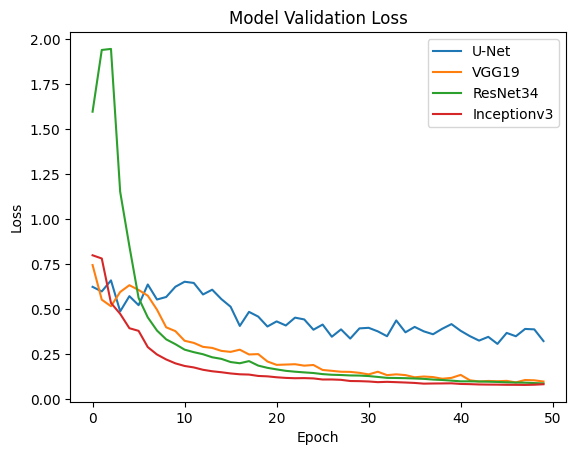

In [115]:
param = 'val_loss'

plt.plot(history_unet.history[param])
plt.plot(history_vgg19.history[param])
plt.plot(history_resnet34.history[param])
plt.plot(history_inceptionv3.history[param])
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['U-Net', 'VGG19', 'ResNet34', 'Inceptionv3'], loc='upper right')
plt.savefig(f'/content/gdrive/MyDrive/Colab Datasets/{param}.png')
plt.show()

In [73]:
def testModel(model, x_test, y_test, treshold=0.7):
  y_pred = model.predict(x_test)
  y_pred_th = y_pred > treshold

  i = np.logical_and(y_test, y_pred_th)
  u = np.logical_or(y_test, y_pred_th)
  iou = np.sum(i) / np.sum(u)
  dice = dice_coef(y_test, y_pred)

  print("IoU: ", iou)
  print("Dice: ", dice)



print("UNET")
testModel(model_unet, x_test, y_test)

preprocess_input = get_preprocessing('vgg19')
X_test_vgg19 = preprocess_input(x_test)
print("\nVGG19")
testModel(model_vgg19, X_test_vgg19, y_test)

preprocess_input = get_preprocessing('resnet34')
X_test_resnet34 = preprocess_input(x_test)
print("\nRESNET34")
testModel(model_resnet34, X_test_resnet34, y_test)

preprocess_input = get_preprocessing('inceptionv3')
X_test_inceptionv3 = preprocess_input(x_test)
print("\nINCEPTIONV3")
testModel(model_inceptionv3, X_test_inceptionv3, y_test)

UNET
1/1 [==============================] - 3s 3s/step
IoU:  0.5530679448958516
Dice:  tf.Tensor(0.7684079, shape=(), dtype=float32)

VGG19
1/1 [==============================] - 17s 17s/step
IoU:  0.8674548336655132
Dice:  tf.Tensor(0.88887376, shape=(), dtype=float32)

RESNET34
1/1 [==============================] - 4s 4s/step
IoU:  0.8586185710478785
Dice:  tf.Tensor(0.88485634, shape=(), dtype=float32)

INCEPTIONV3
1/1 [==============================] - 7s 7s/step
IoU:  0.8763096208910359
Dice:  tf.Tensor(0.904719, shape=(), dtype=float32)


1/1 [==============================] - 0s 482ms/step


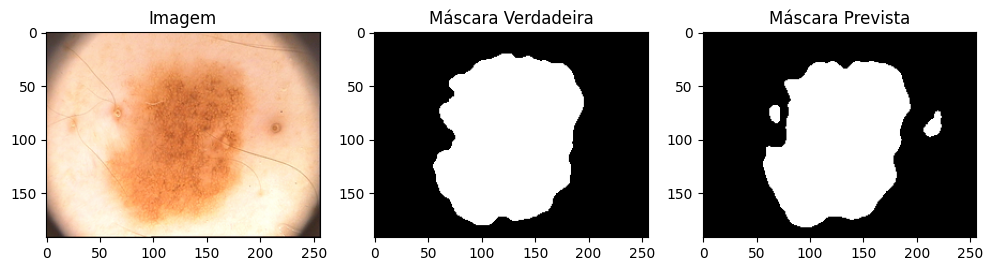

In [70]:
import random
number = 9

result = 'inceptionv3'

img1 = X_test_inceptionv3[number]
img = x_test[number]
input = np.expand_dims(img1, 0)
mask = y_test[number]

y_pred = model_inceptionv3.predict(input)
y_pred_th = y_pred > 0.7

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Imagem')
plt.imshow(img)
plt.subplot(232)
plt.title('Máscara Verdadeira')
plt.imshow(mask[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Máscara Prevista')
plt.imshow(y_pred_th[0, :, :, 0], cmap='gray')
plt.savefig(f'/content/gdrive/MyDrive/Colab Datasets/{result}.png')
plt.show()